Looking at all of the "best" stars (p14) that have IUE data, and making a proposal ready plot

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/2tb_ext_hd/hddata/hwo/data/iue/'

Star list : HIP 104214 (61 Cyg A), HIP 108870 (eps Ind), HIP
19849 A (40 Eri A), HIP 96100 (sig Dra), HIP 61317 (bet CVn), HIP 15457 (kap1 Cet),
HIP 57443 A (HR 4523)

Has IUE:  
HIP 108870 (eps Ind)  
HIP 19849 A  
HIP 96100  
HIP 61317  
HIP 15457  
HIP 57443 A  


In [4]:
stars = os.listdir(path)
stars

['HIP_108870',
 'HIP_15457',
 'HIP_19849_A',
 'HIP_57443_A',
 'HIP_61317',
 'HIP_96100']

HIP_108870


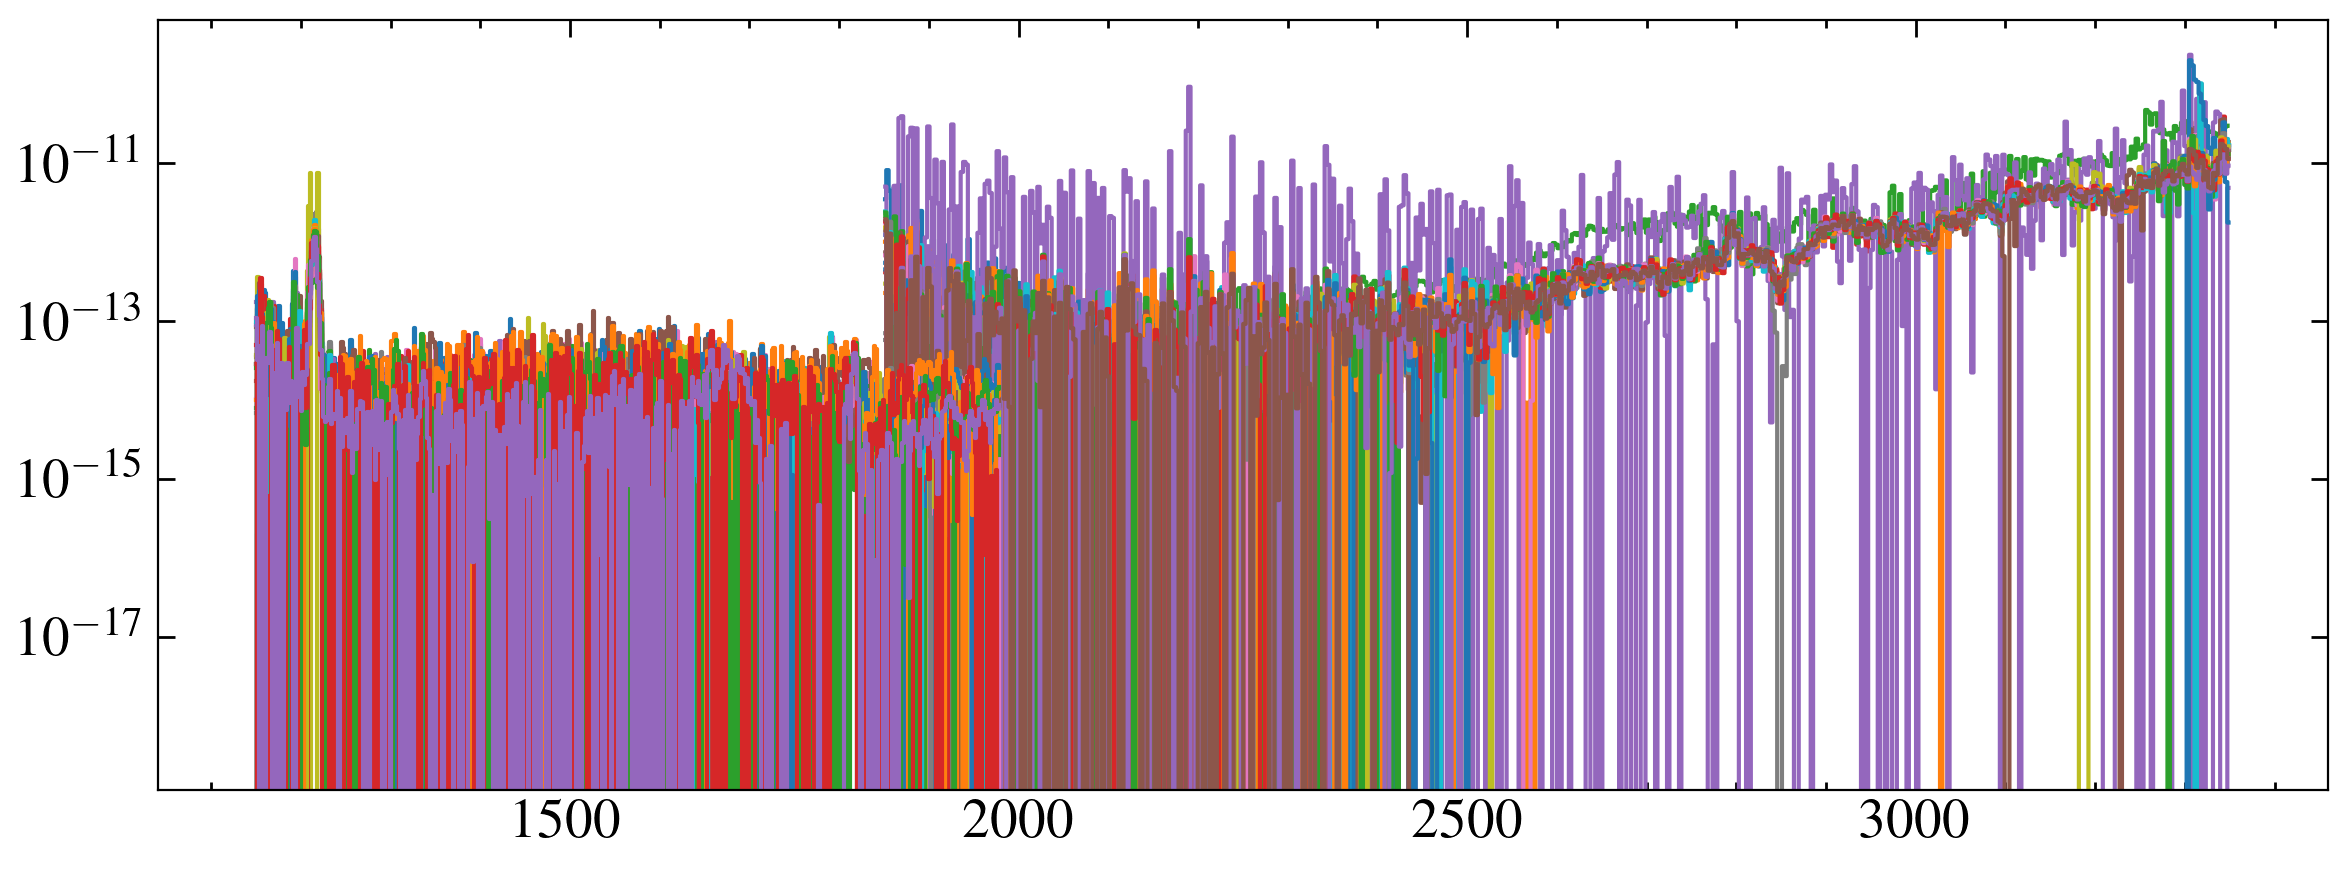

HIP_15457


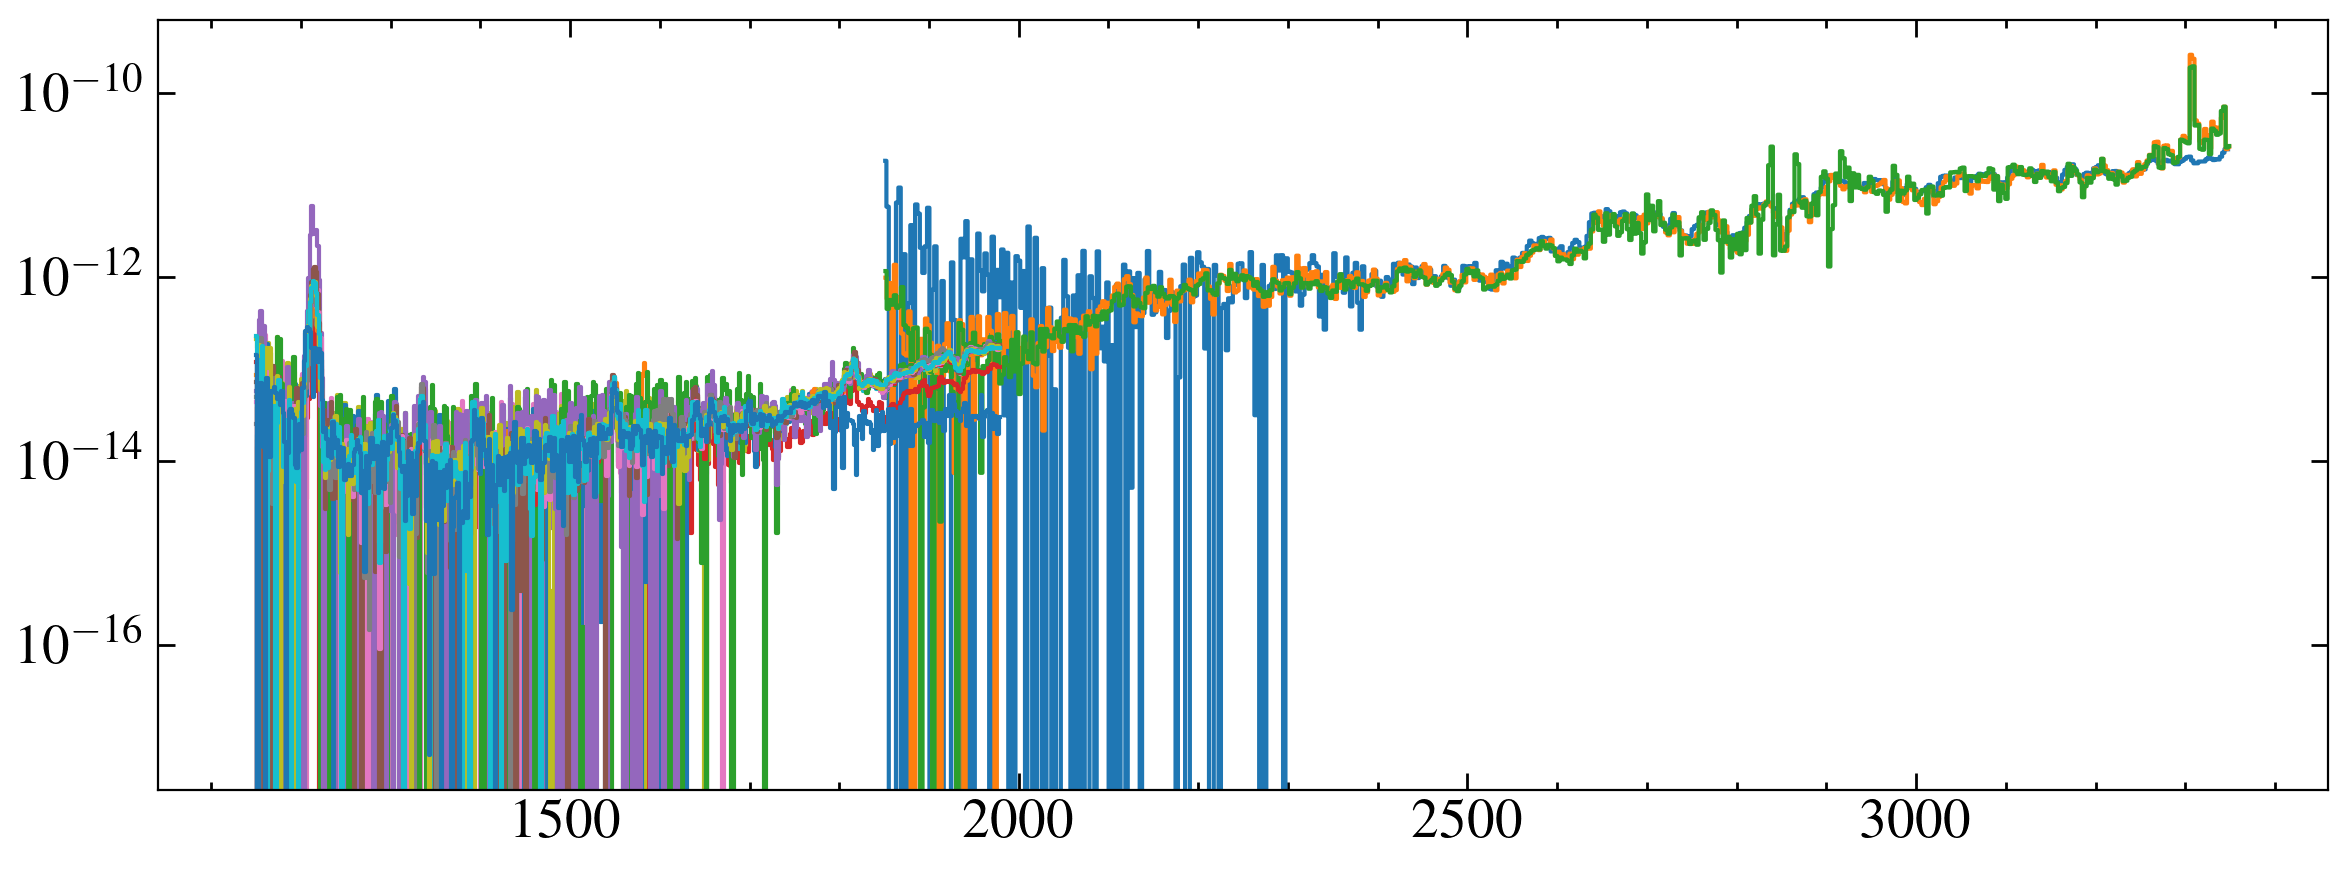

HIP_19849_A


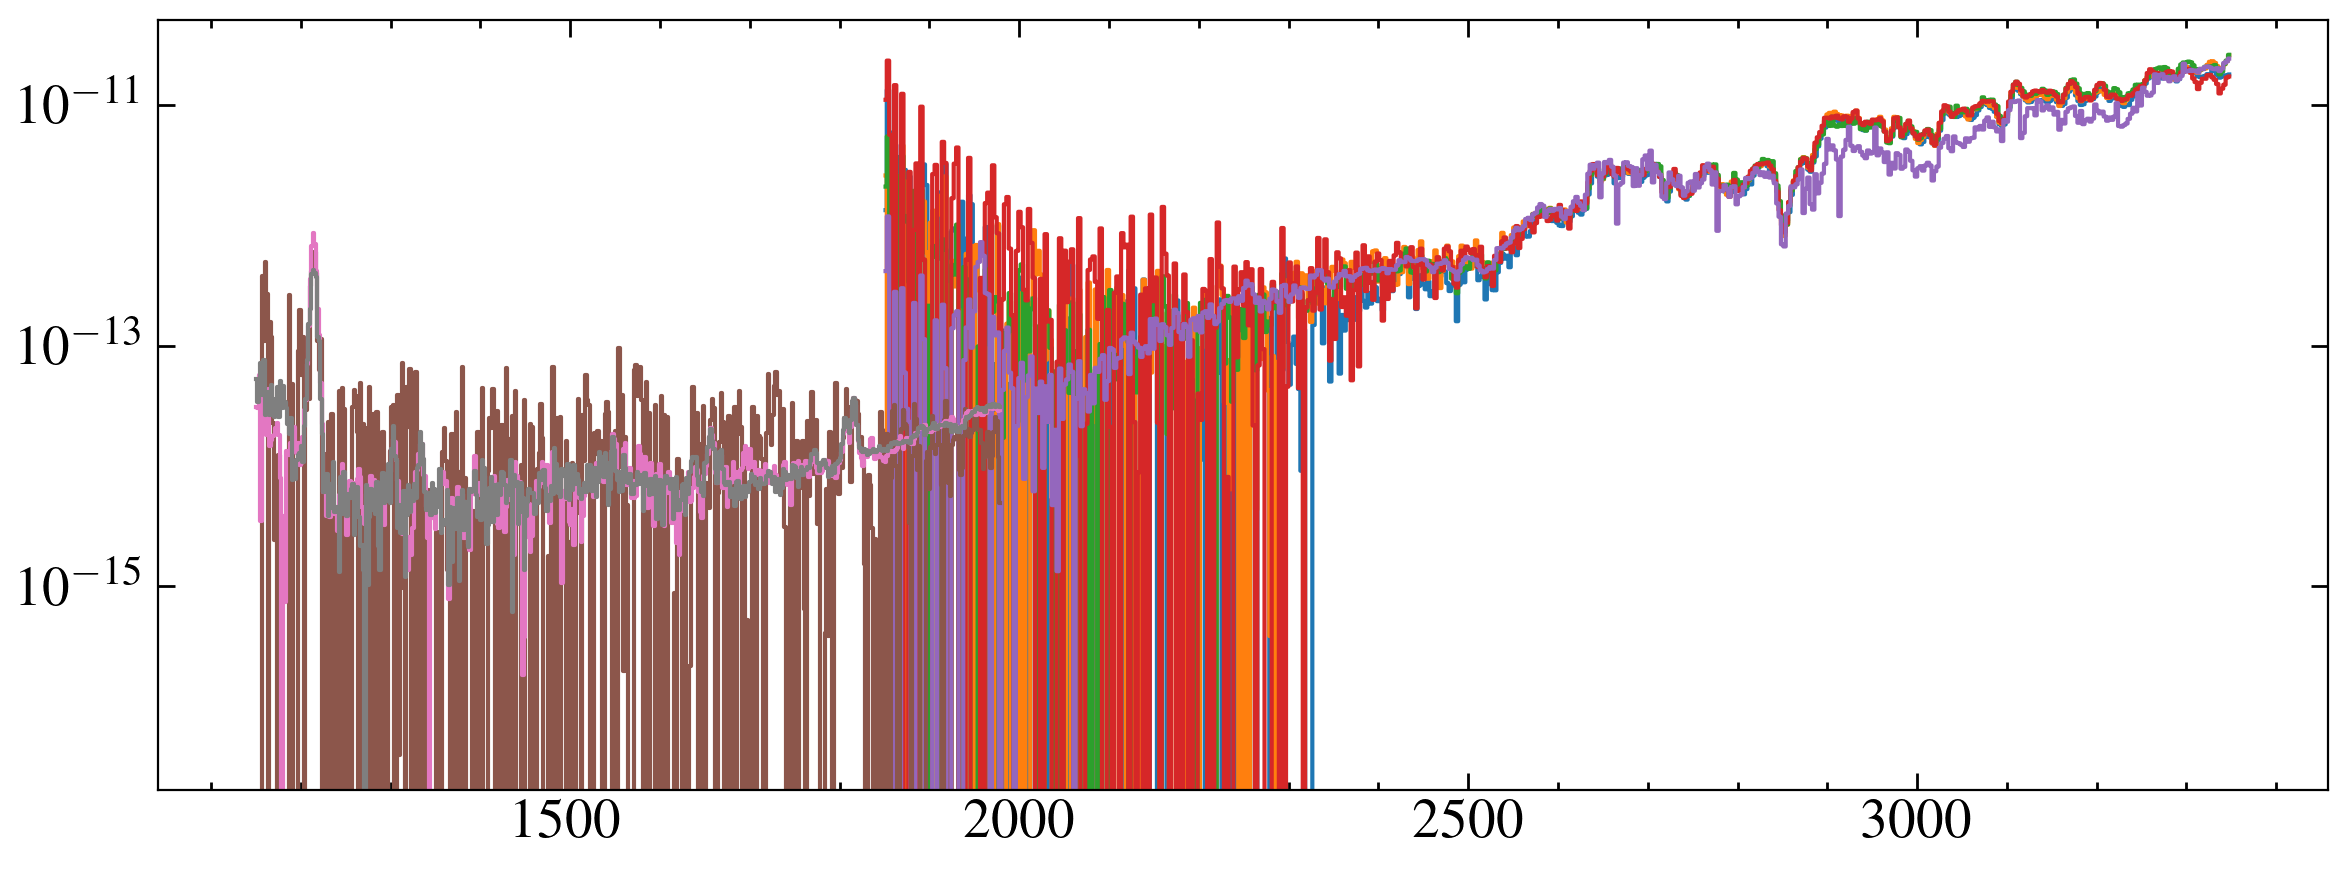

HIP_57443_A


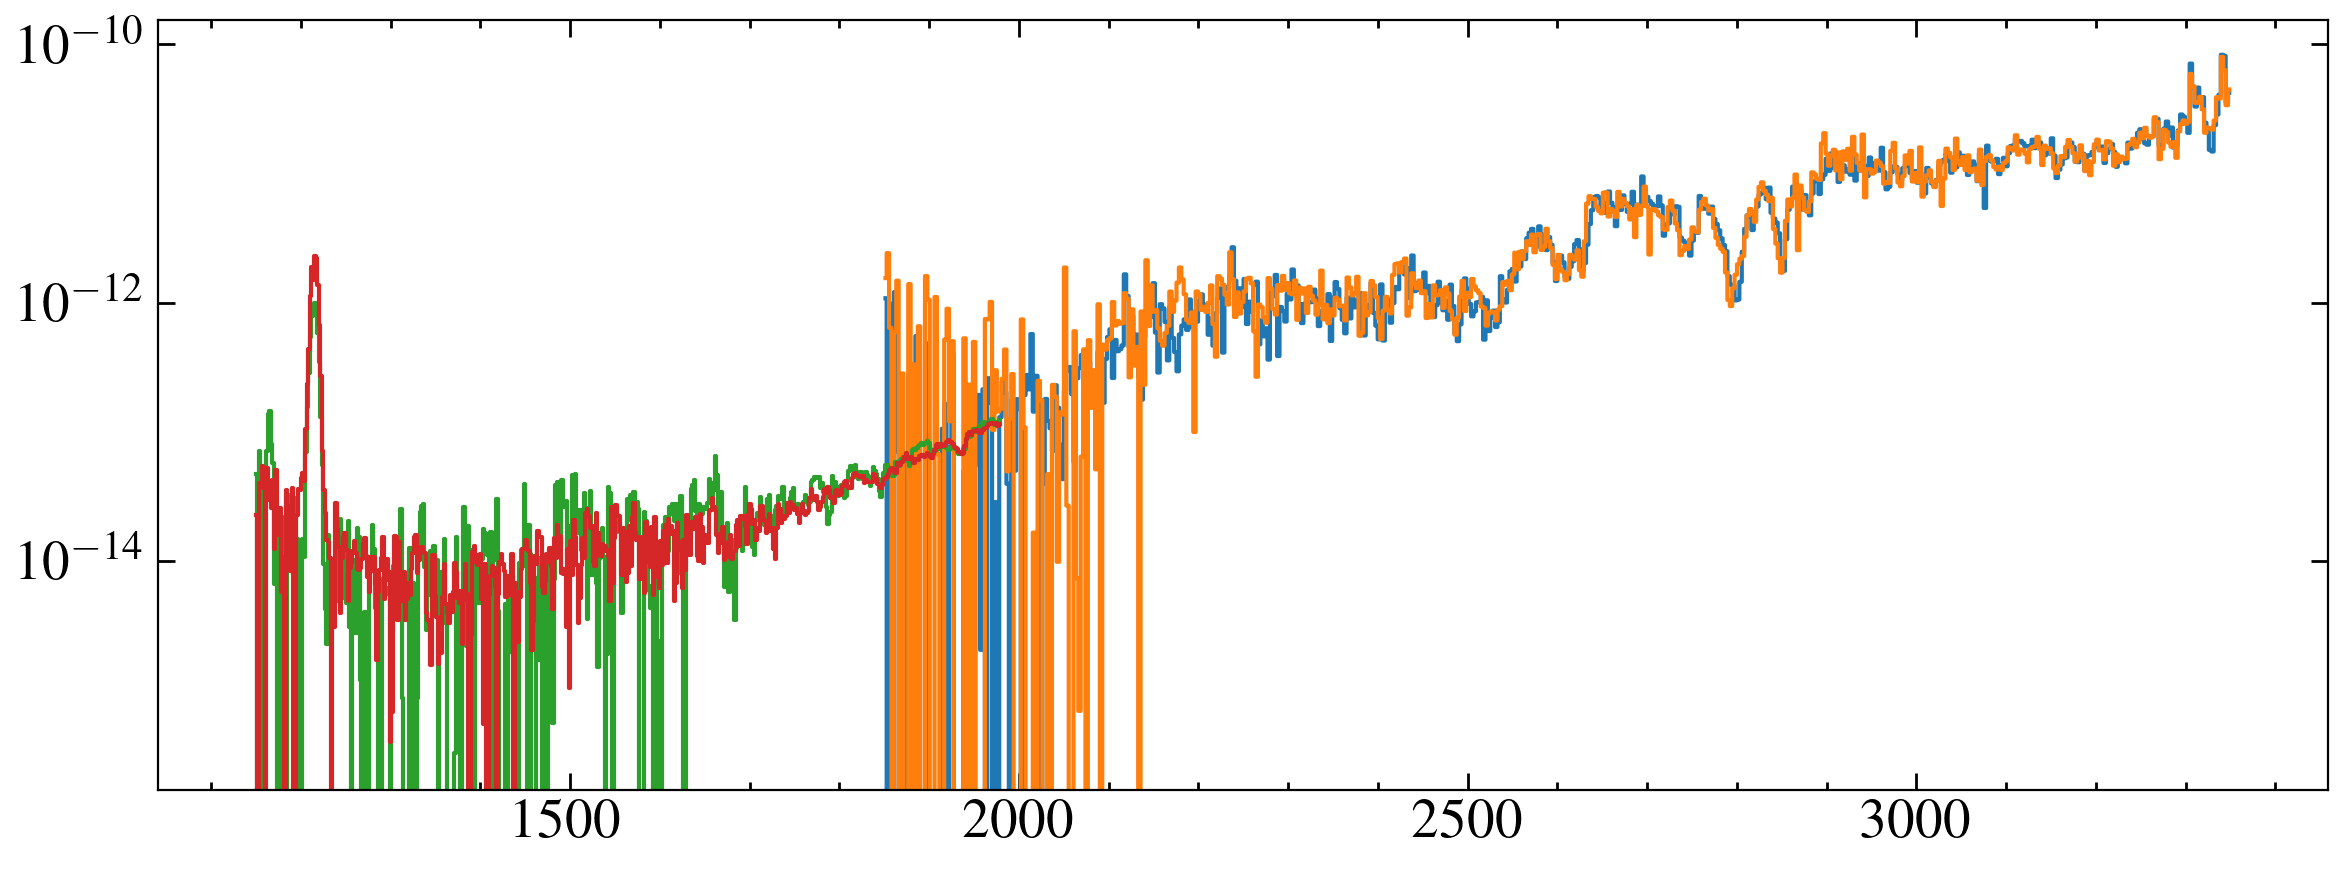

HIP_61317


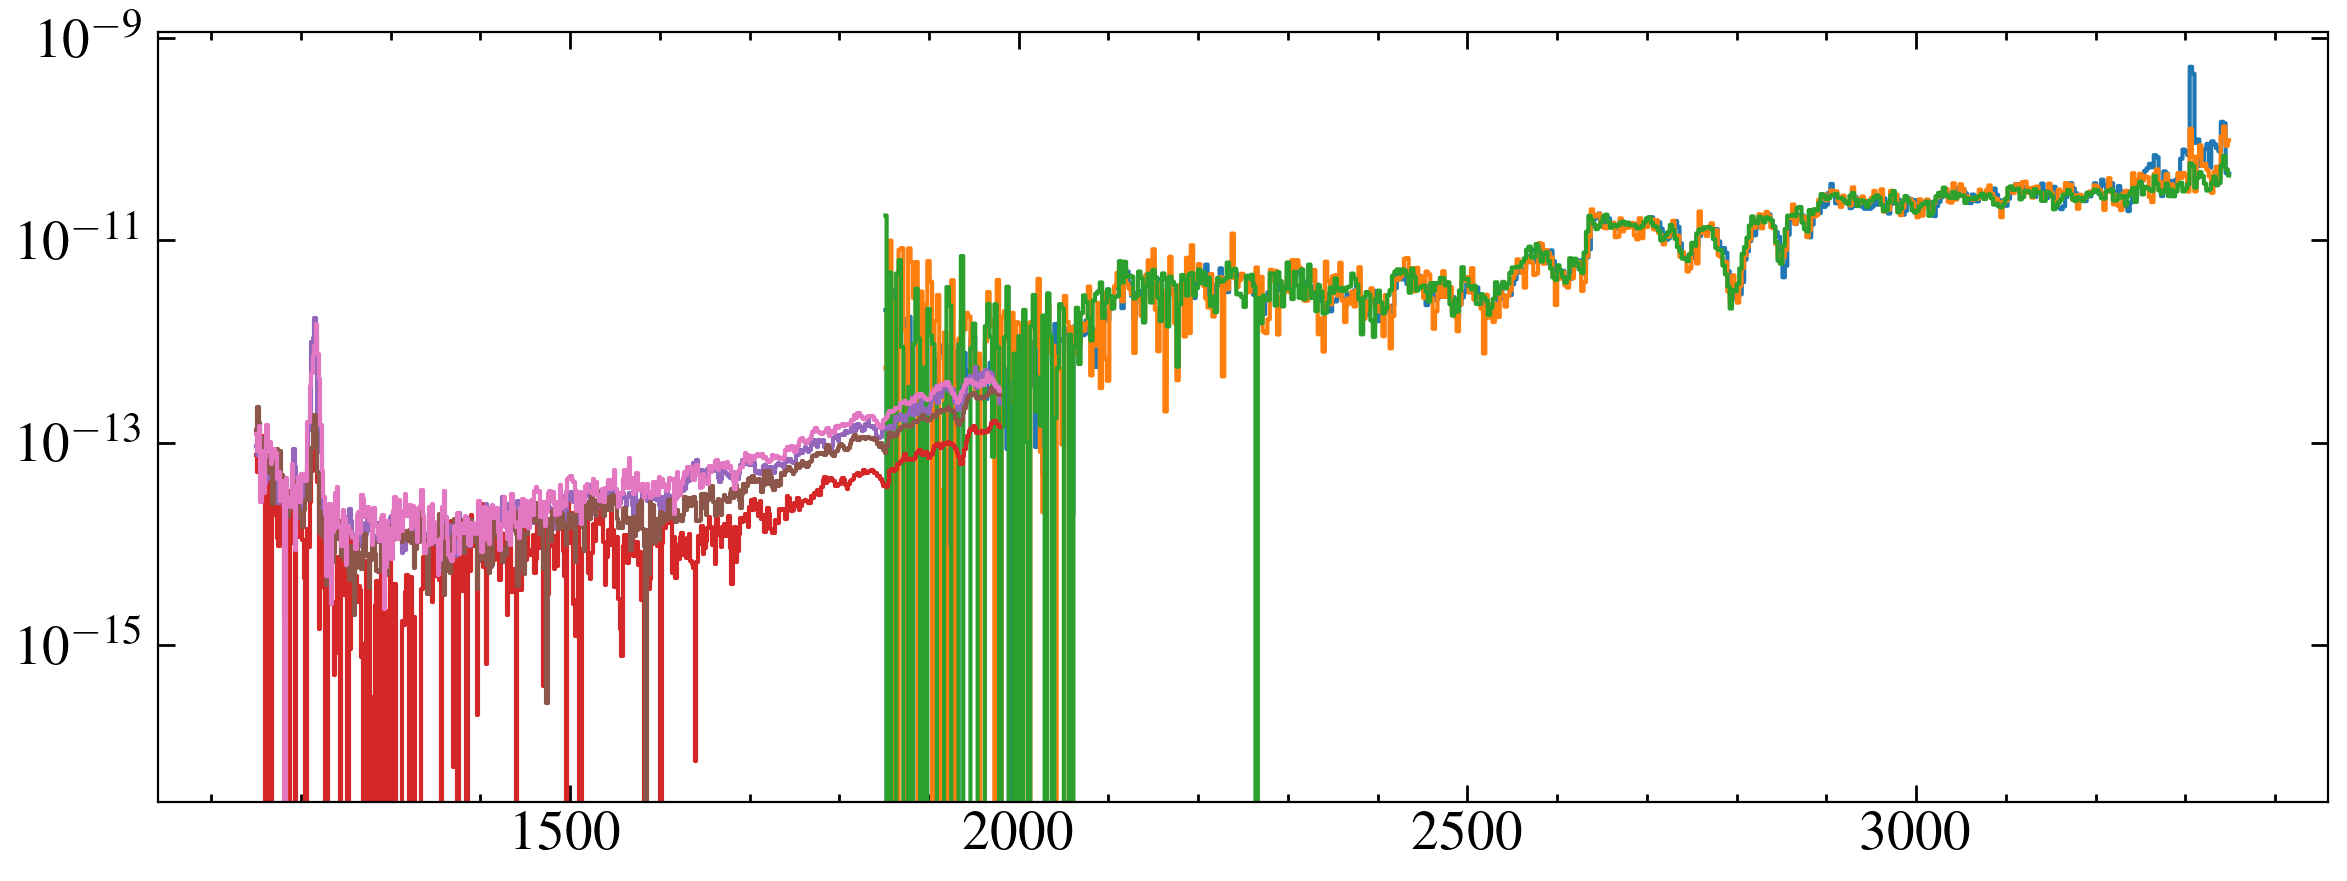

HIP_96100


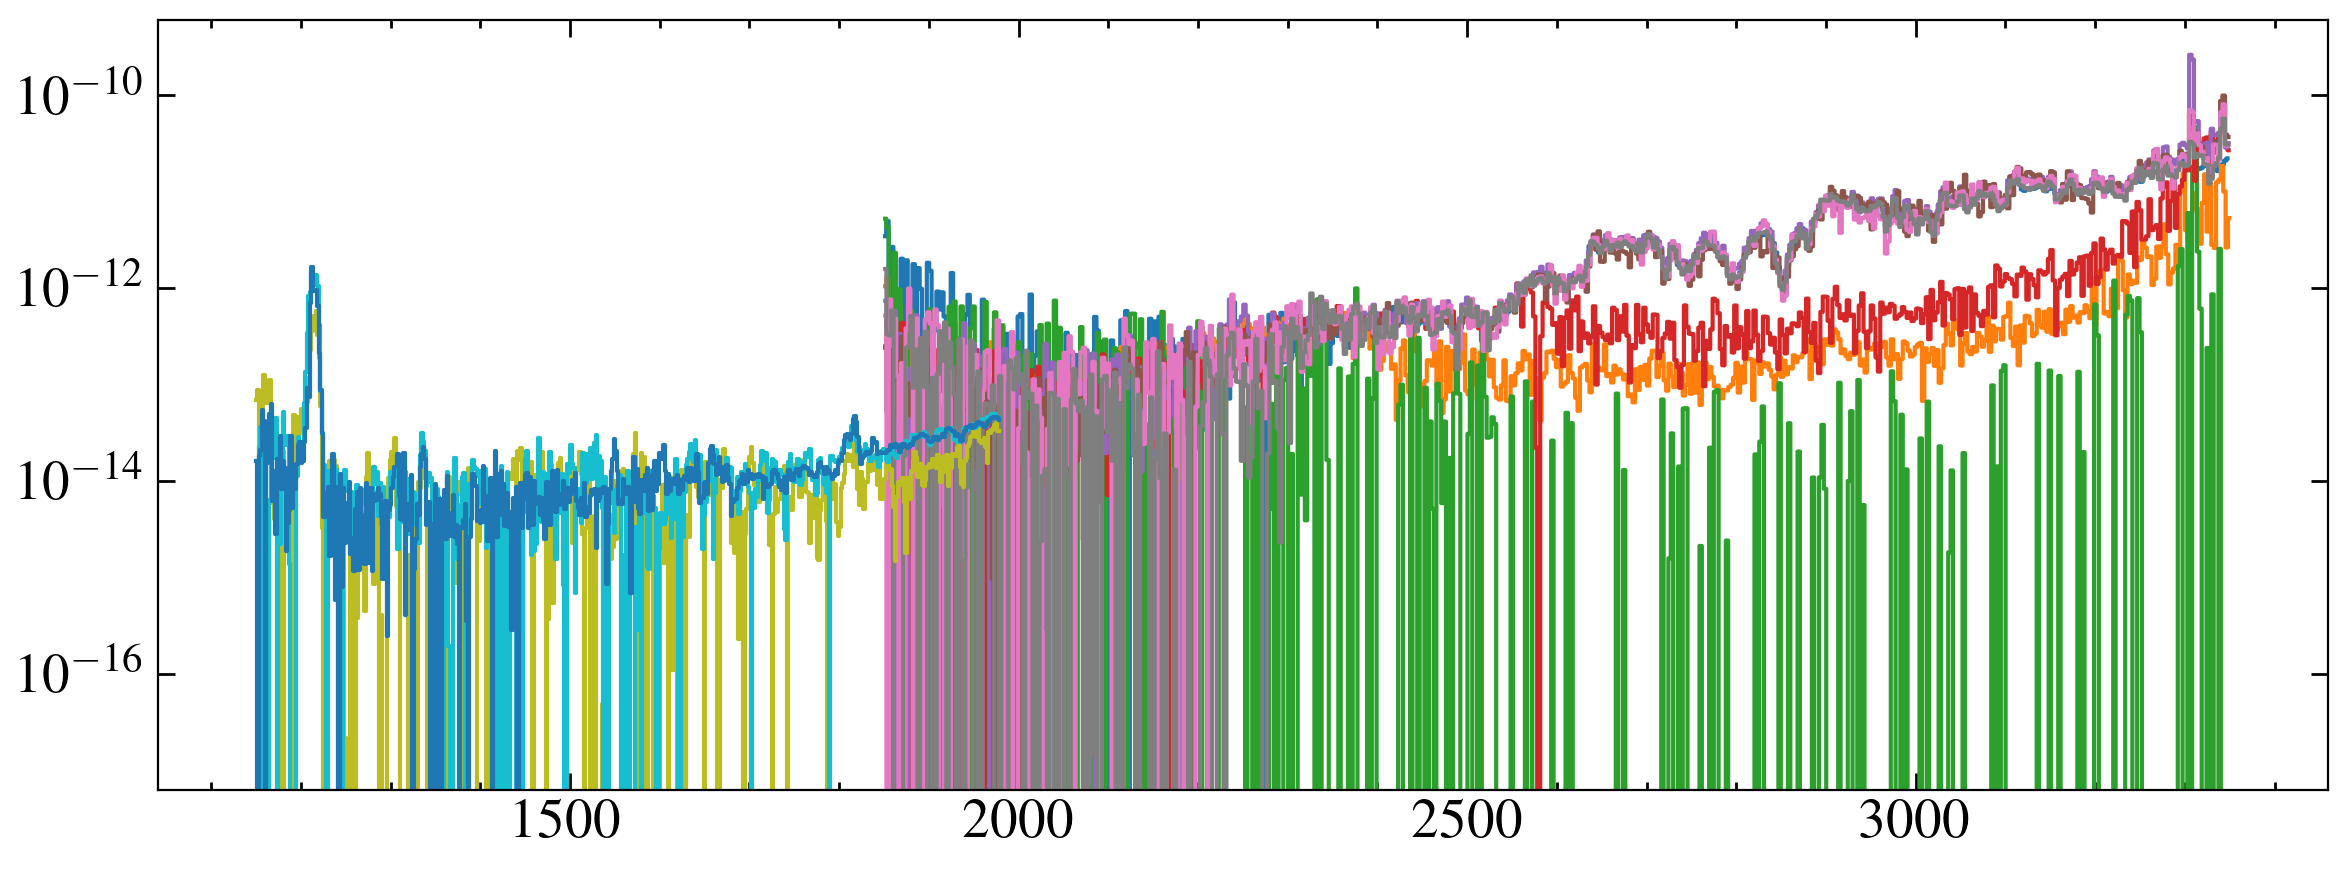

In [5]:
for star in stars:
    print(star)
    iuespecs = glob.glob('{}{}/*vo.fits'.format(path, star))
    fig, ax = plt.subplots()

    for spec in iuespecs:
        data = fits.getdata(spec, 1)[0]
        w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
        # ax.step(w[dq==0],f[dq==0], where='mid')
        ax.step(w,f, where='mid')

    ax.set_yscale('log')
    # ax.set_xscale('log')
    # ax.set_ylim(1e-15)
    
    plt.show()


Pick good examples of each star, run them through remove_negatives (?) then plot? Or just coadd?

In [6]:
# goodspecs = {'HIP-108870':,
#  'HIP-15457':['lwp15284mxlo_vo.fits',
#  'HIP-19849A':,
#  'HIP-57443A':,
#  'HIP-61317':,
#  'HIP-96100':}

In [7]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

HIP_108870


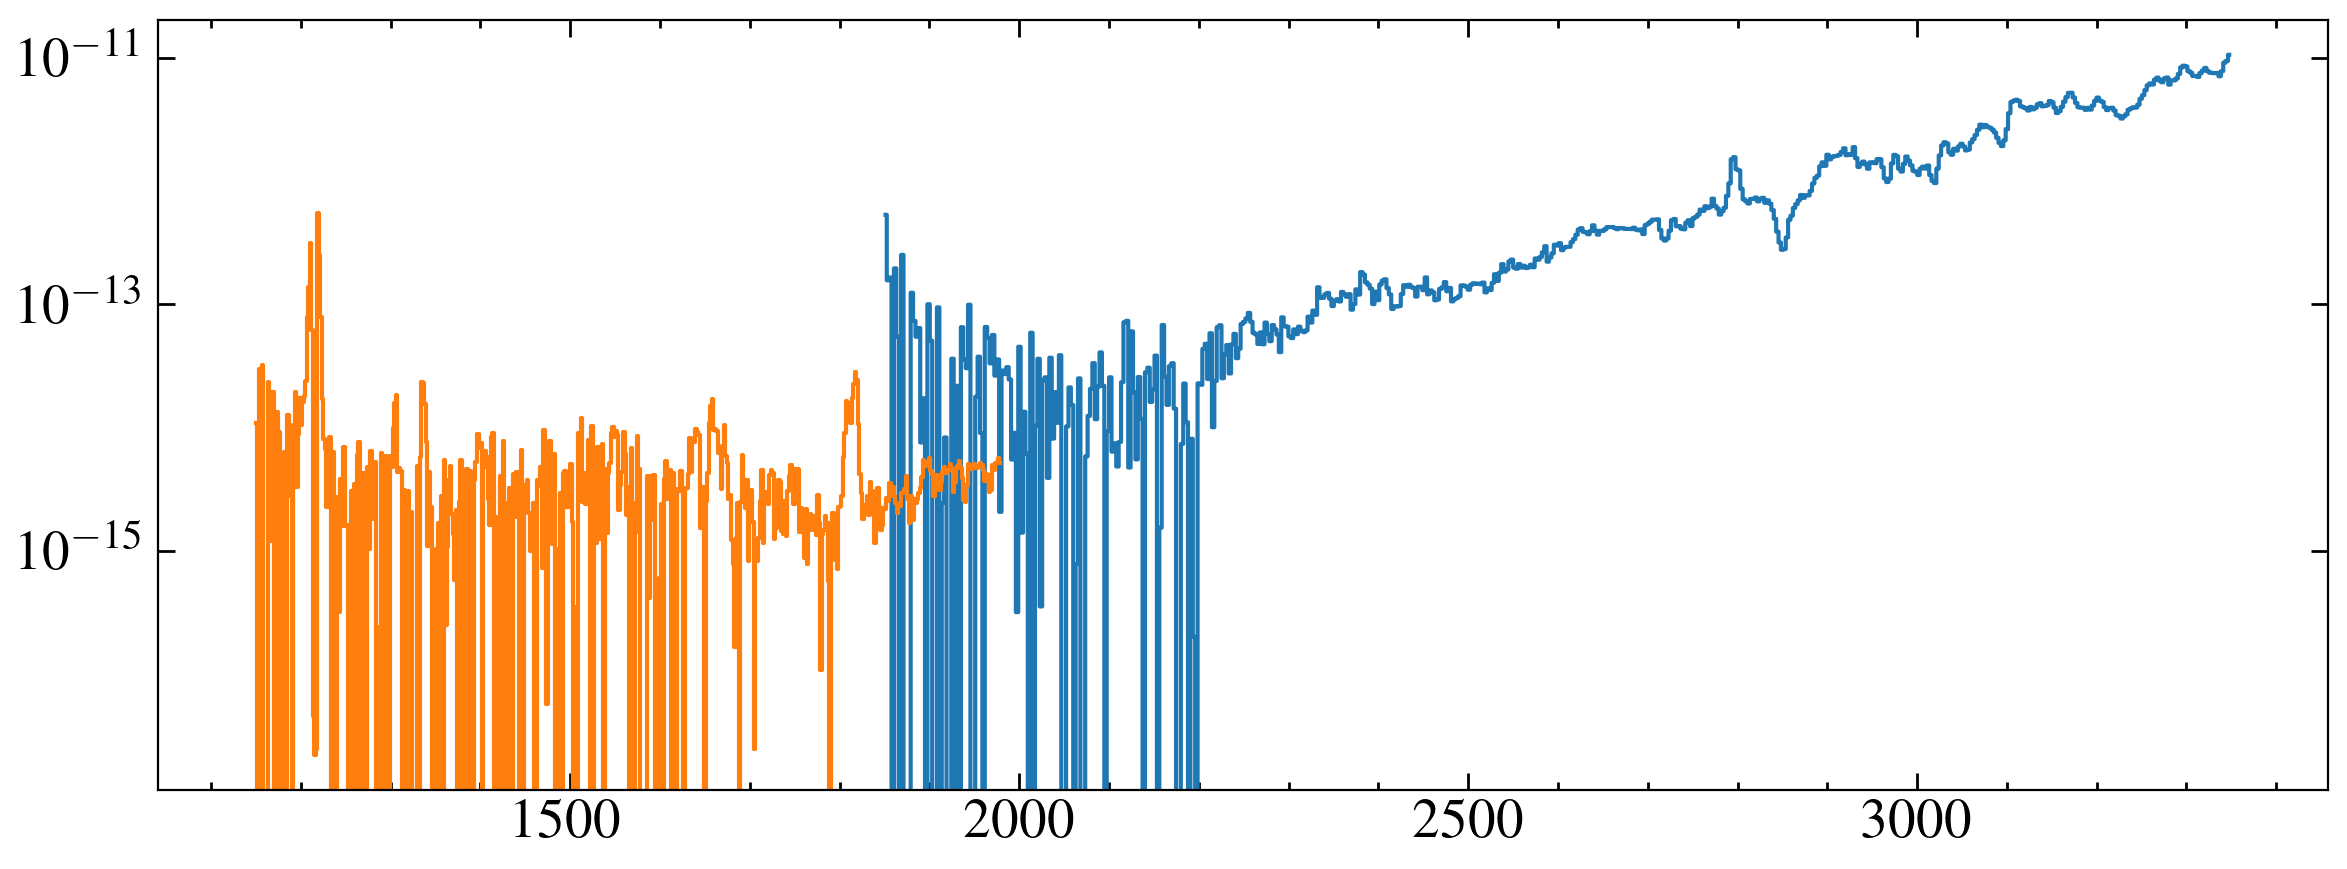

HIP_15457


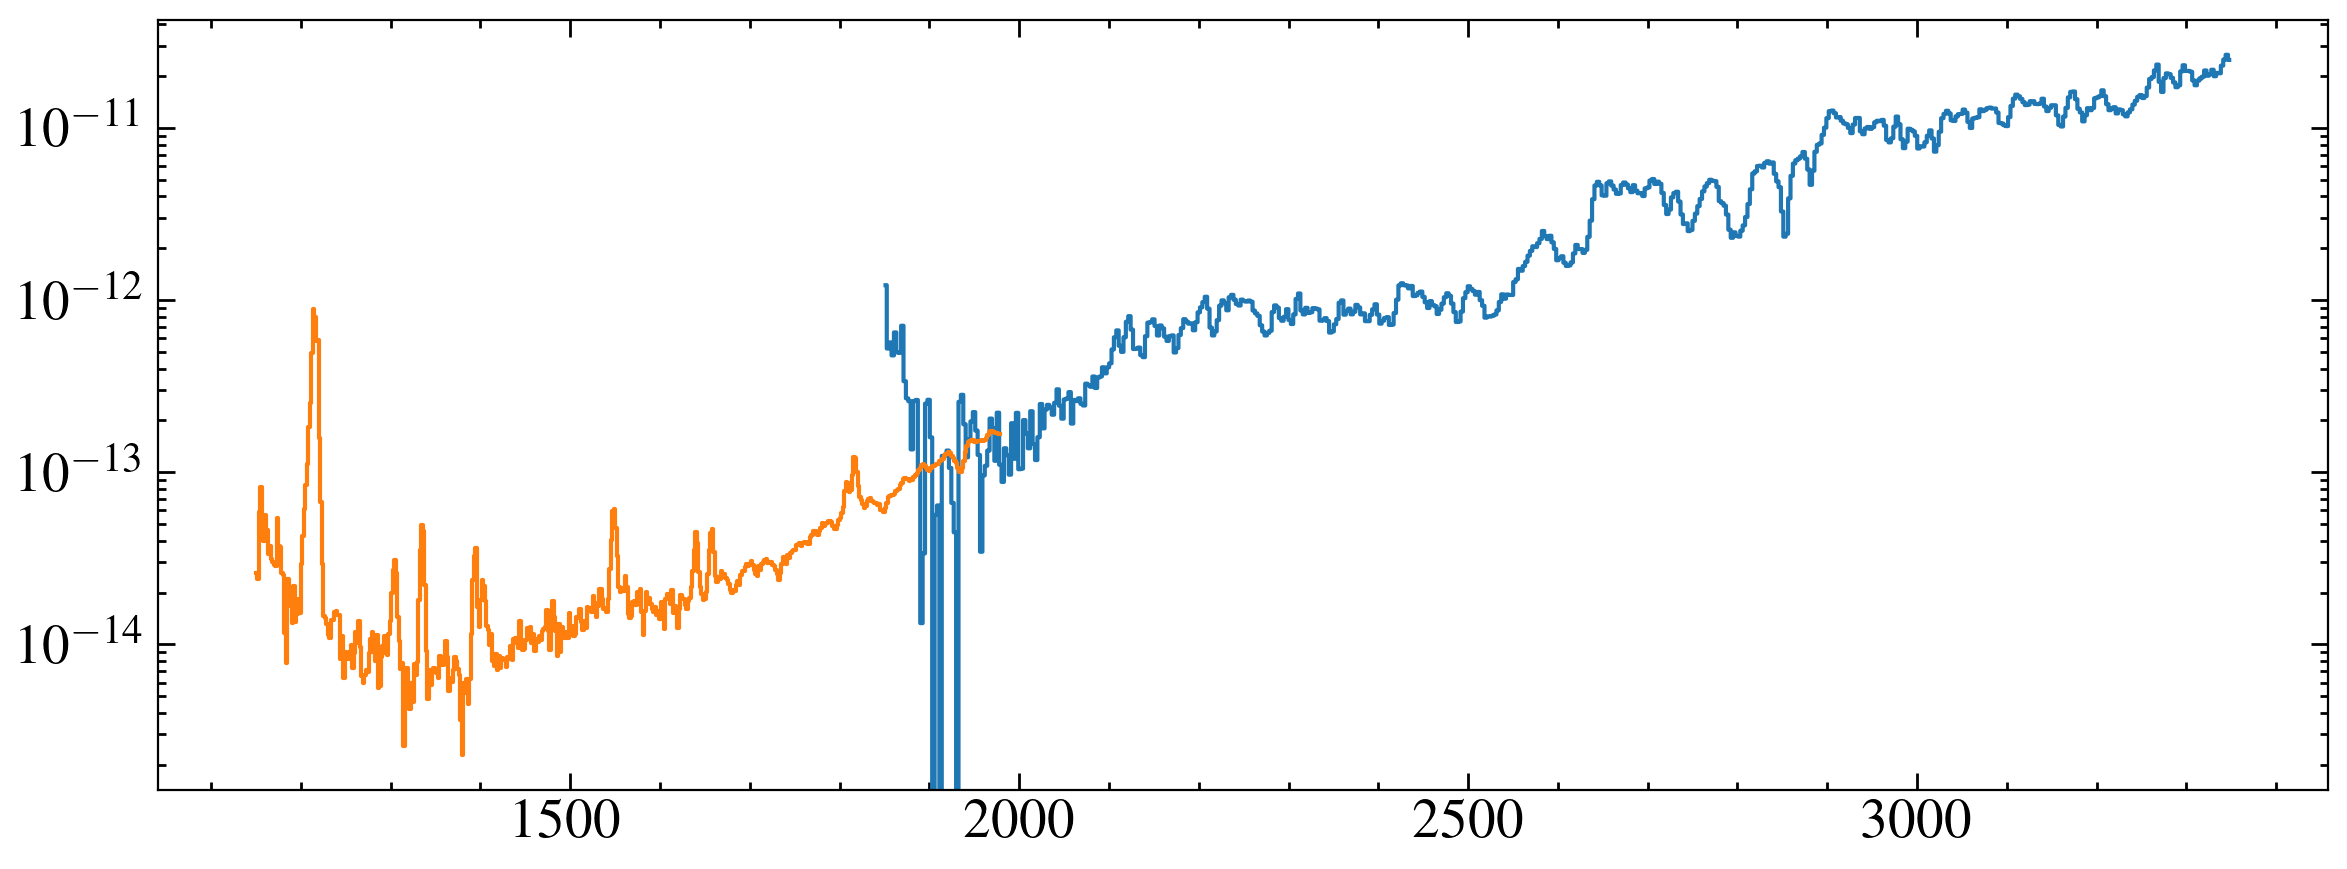

HIP_19849_A


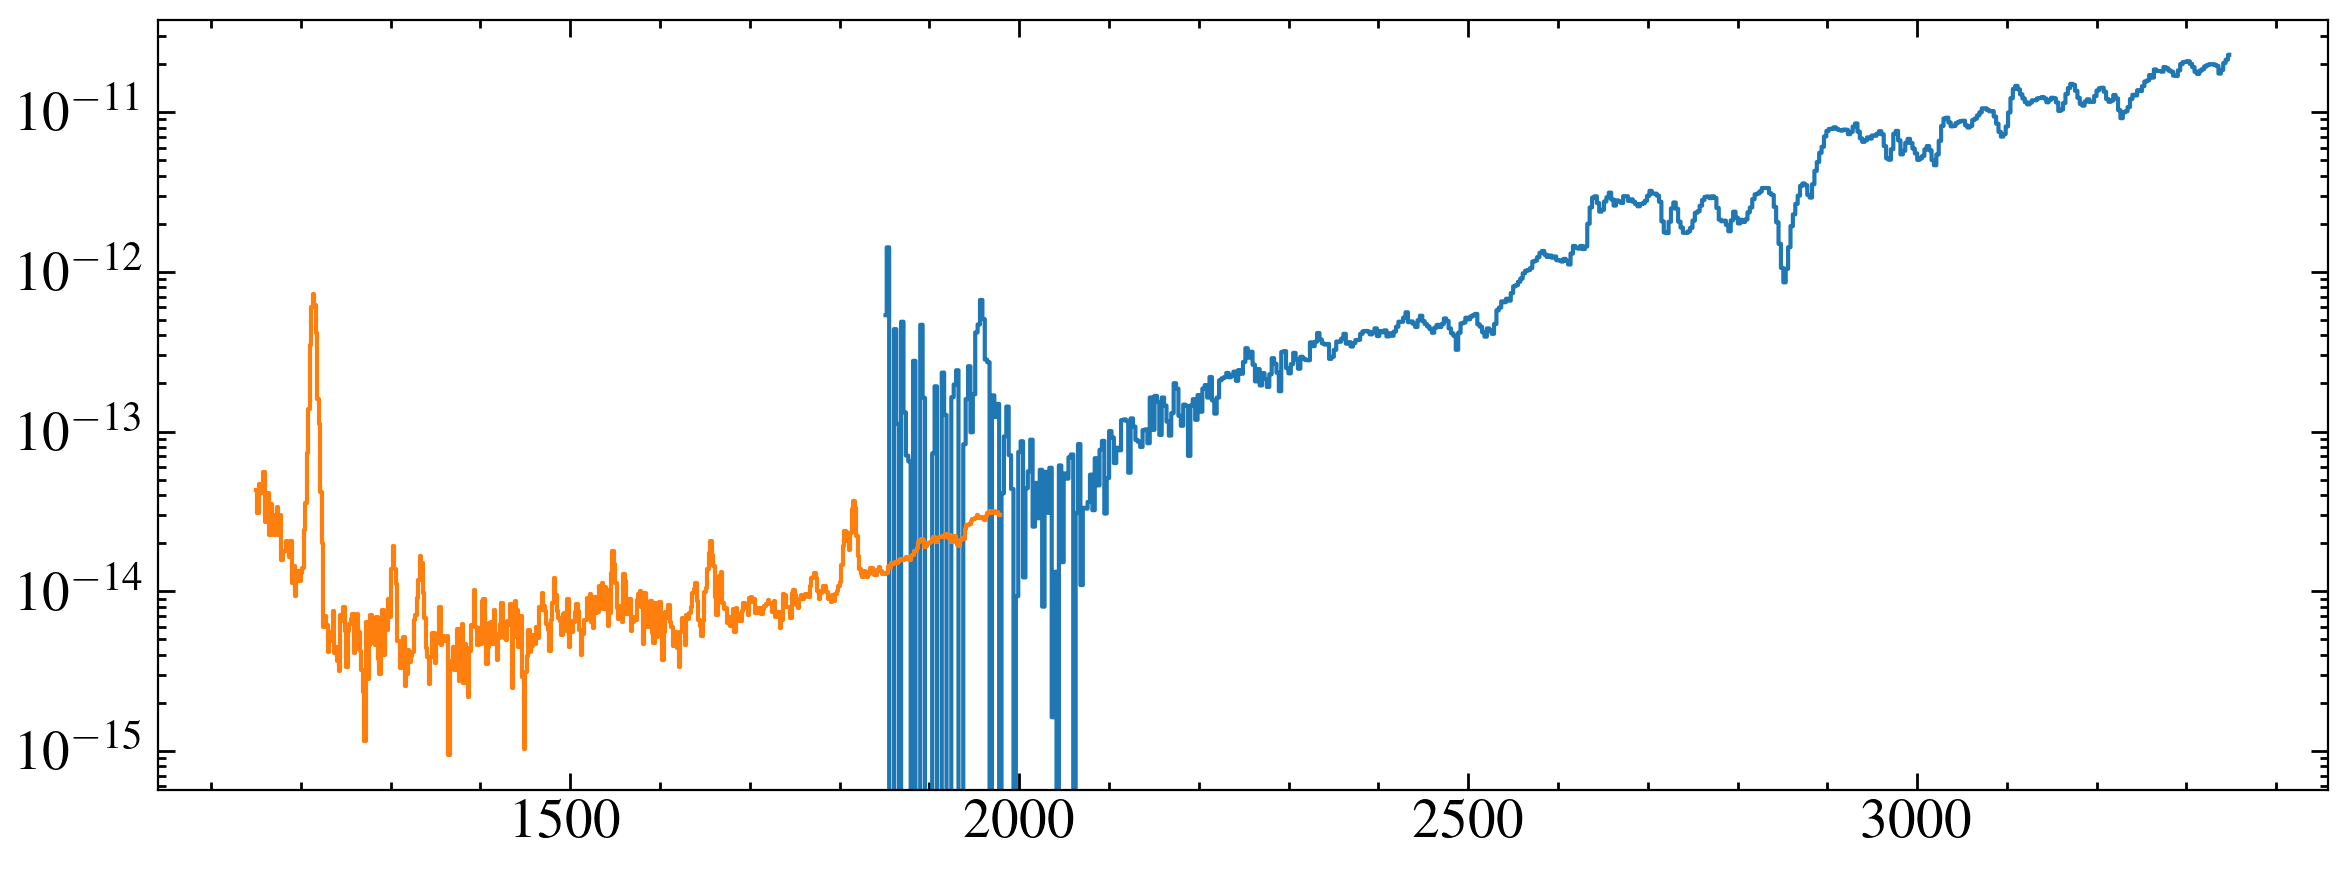

HIP_57443_A


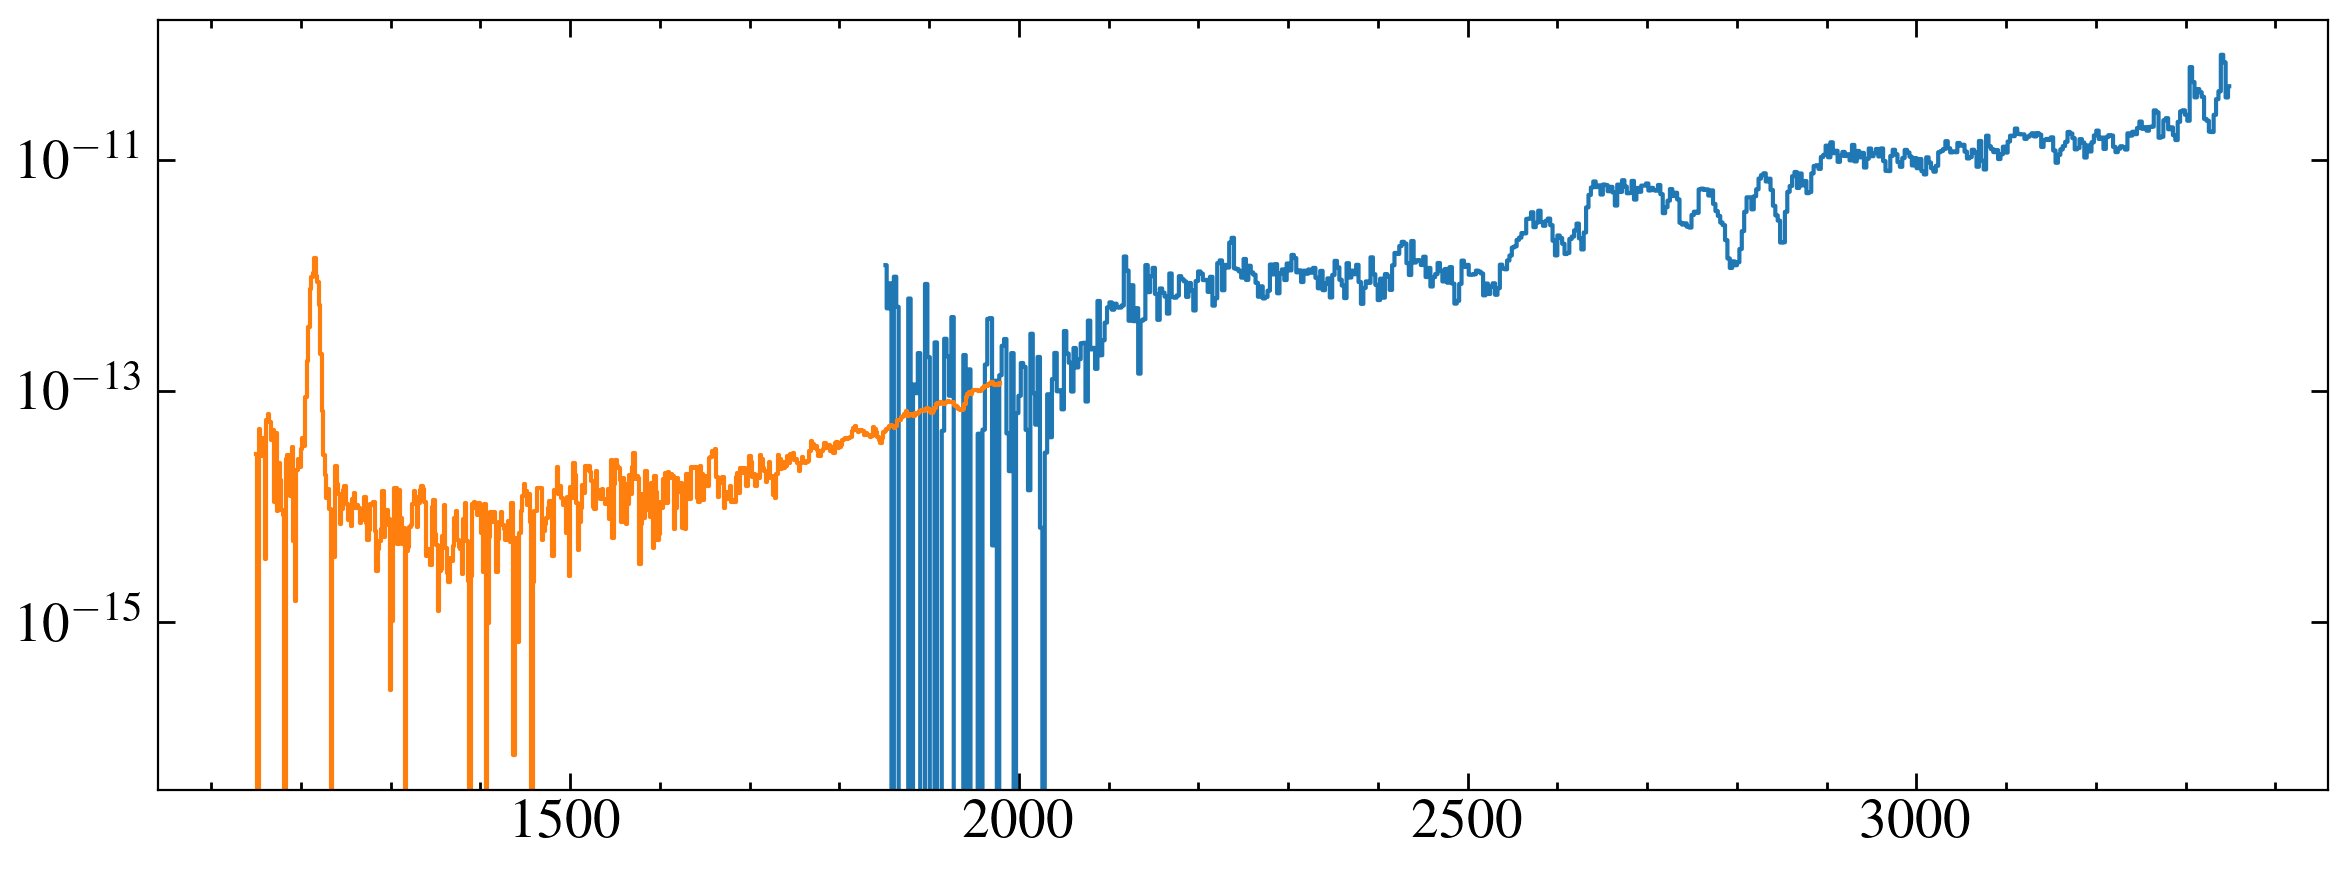

HIP_61317


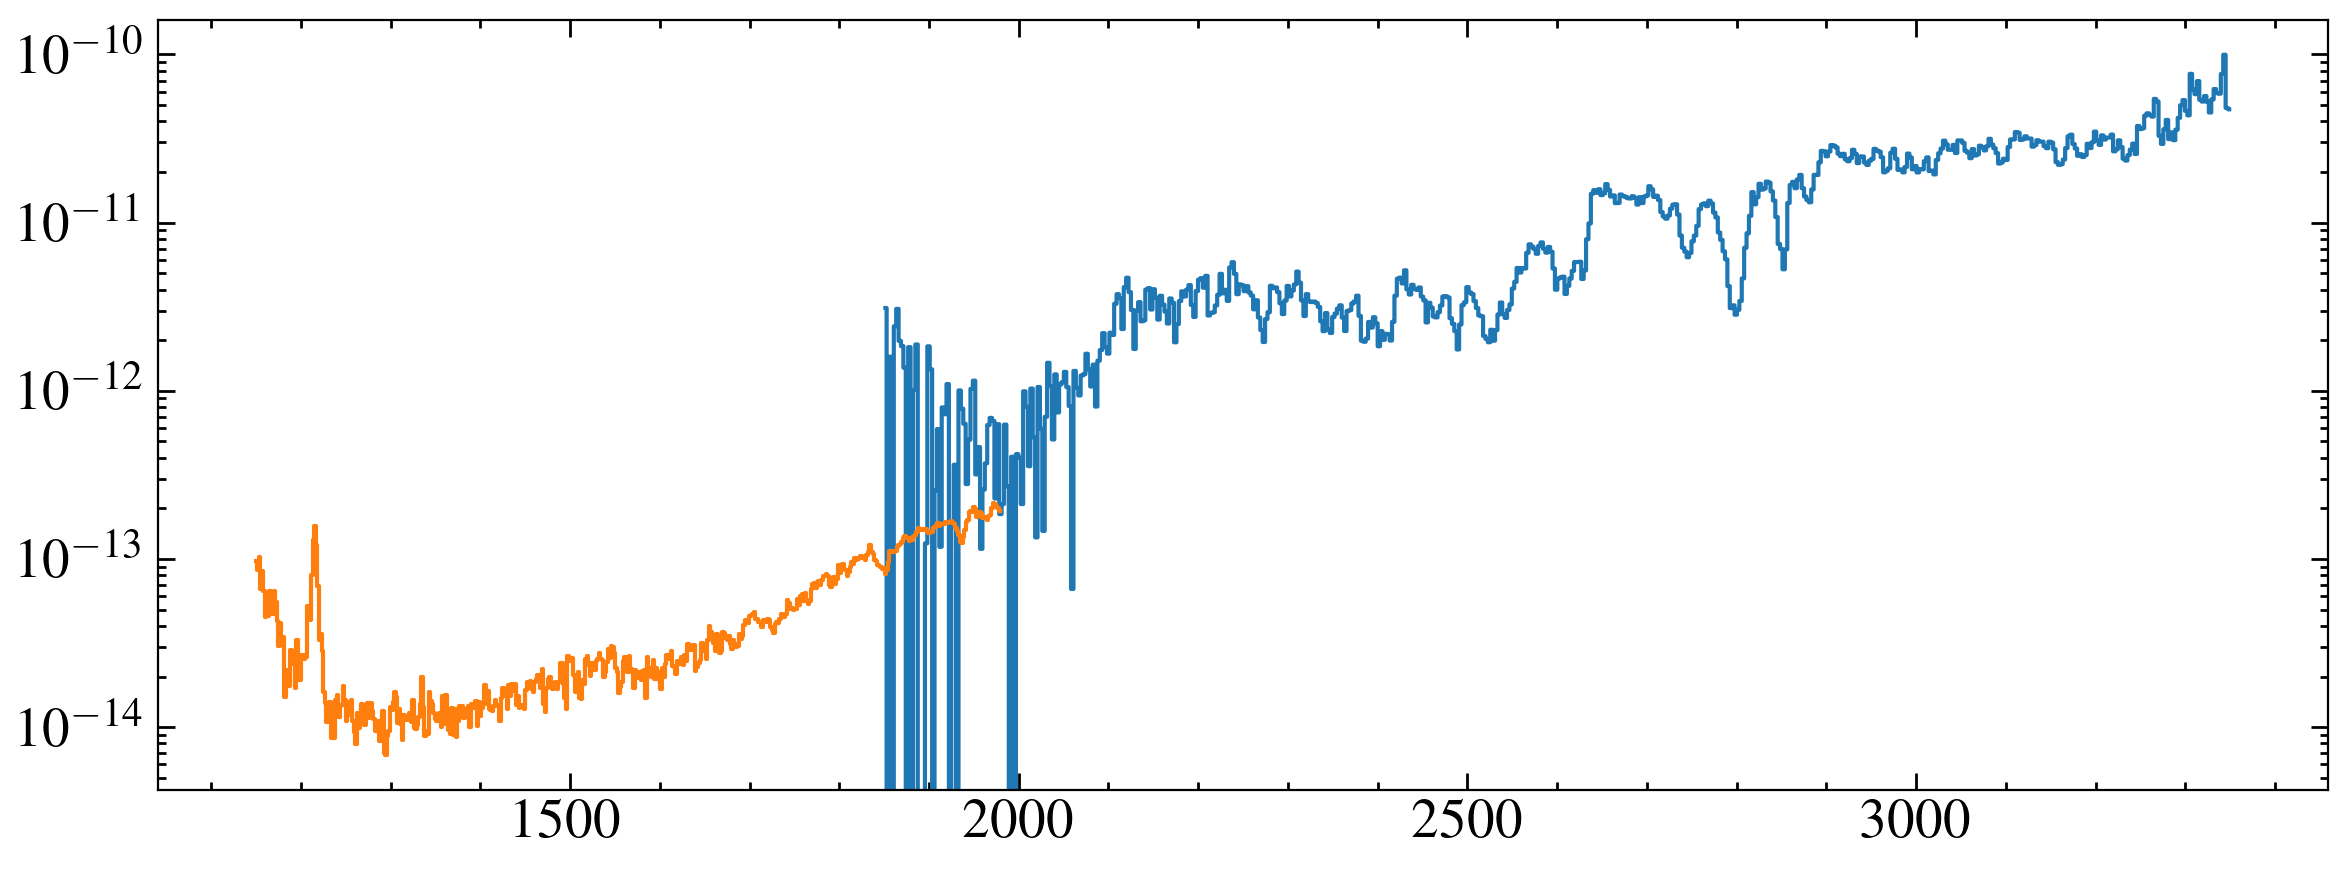

HIP_96100


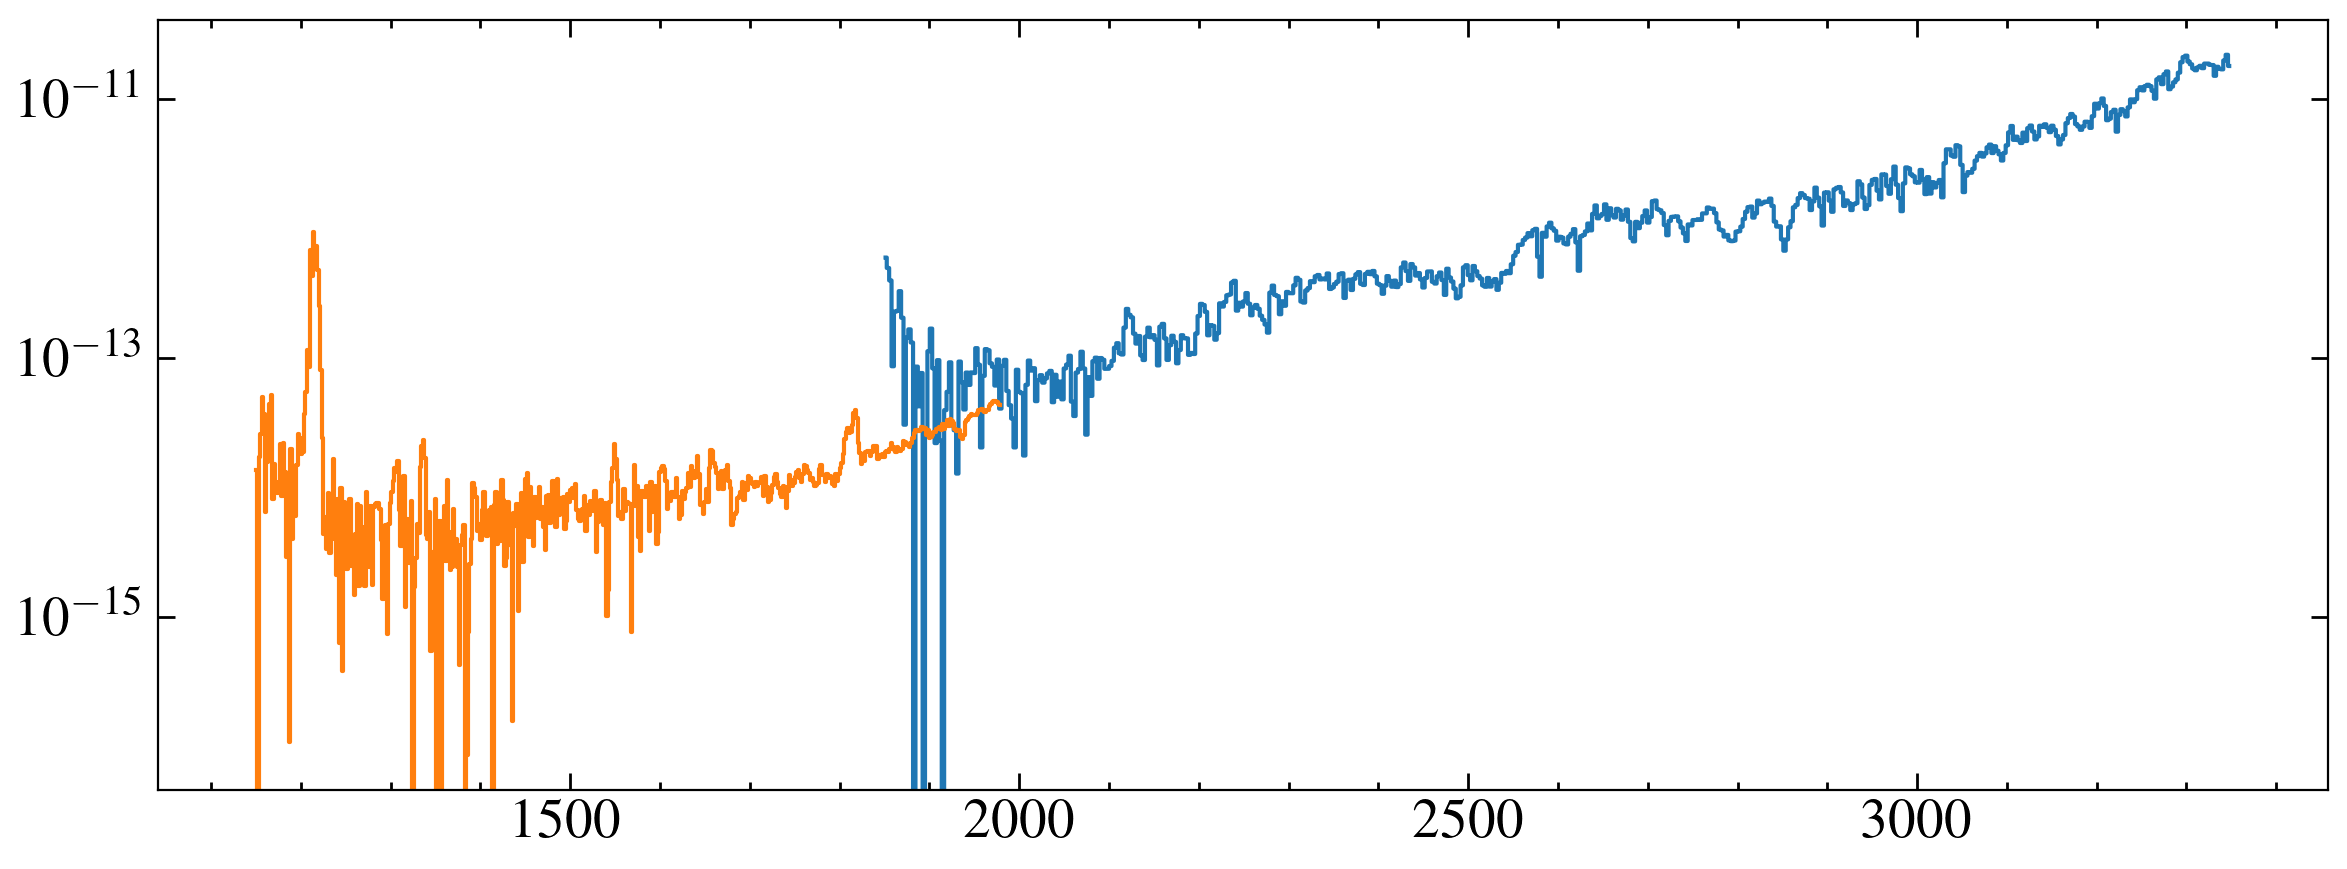

In [8]:
for star in stars:
    print(star)
    iuespecs = glob.glob('{}{}/*vo.fits'.format(path, star))
    fig, ax = plt.subplots()
    
    swp_f = []
    swp_e = []
    lwr_f = []
    lwr_e = []
    n = 0
    o = 0
    for spec in iuespecs:
        data = fits.getdata(spec, 1)[0]
        w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
       
        if os.path.split(spec)[1][0:3] == 'swp':
            if n == 0:
                w_swp = w
                swp_f.append(f)
                swp_e.append(e)
            else:
                fi = interp1d(w, f, fill_value='extrapolate')(w_swp)
                ei = interp1d(w, e, fill_value='extrapolate')(w_swp)
                swp_f.append(fi)
                swp_e.append(ei)
            n += 1
        if os.path.split(spec)[1][0:2] == 'lw':
            if o == 0:
                w_lwr = w
                lwr_f.append(f)
                lwr_e.append(e)
            else:
                fi = interp1d(w, f, fill_value='extrapolate')(w_lwr)
                ei = interp1d(w, e, fill_value='extrapolate')(w_lwr)
                lwr_f.append(fi)
                lwr_e.append(ei)
            o += 1
            
    # print(lwr_e)
    f_lwr, e_lwr = spectra_adder(np.array(lwr_f), np.array(lwr_e))
    f_swp, e_swp = spectra_adder(np.array(swp_f), np.array(swp_e))
                
        
            # ax.step(w[dq==0],f[dq==0], where='mid')
            # ax.step(w,f, where='mid')
            
    smask = (f_swp > 0) #& (w_swp < w_lwr[0])
    lmask = (f_lwr > 0) & (w_lwr > w_swp[-1])
    # ax.step(w_lwr[lmask], f_lwr[lmask], where='mid')
    ax.step(w_lwr, f_lwr, where='mid')
    # ax.step(w_swp[smask], f_swp[smask], where='mid')
    ax.step(w_swp, f_swp, where='mid')
            

    ax.set_yscale('log')
    # ax.set_xscale('log')
    # ax.set_ylim(1e-15)
    
    plt.show()

In [9]:
startab = Table.read('hwo_target_list.csv', data_start=2)

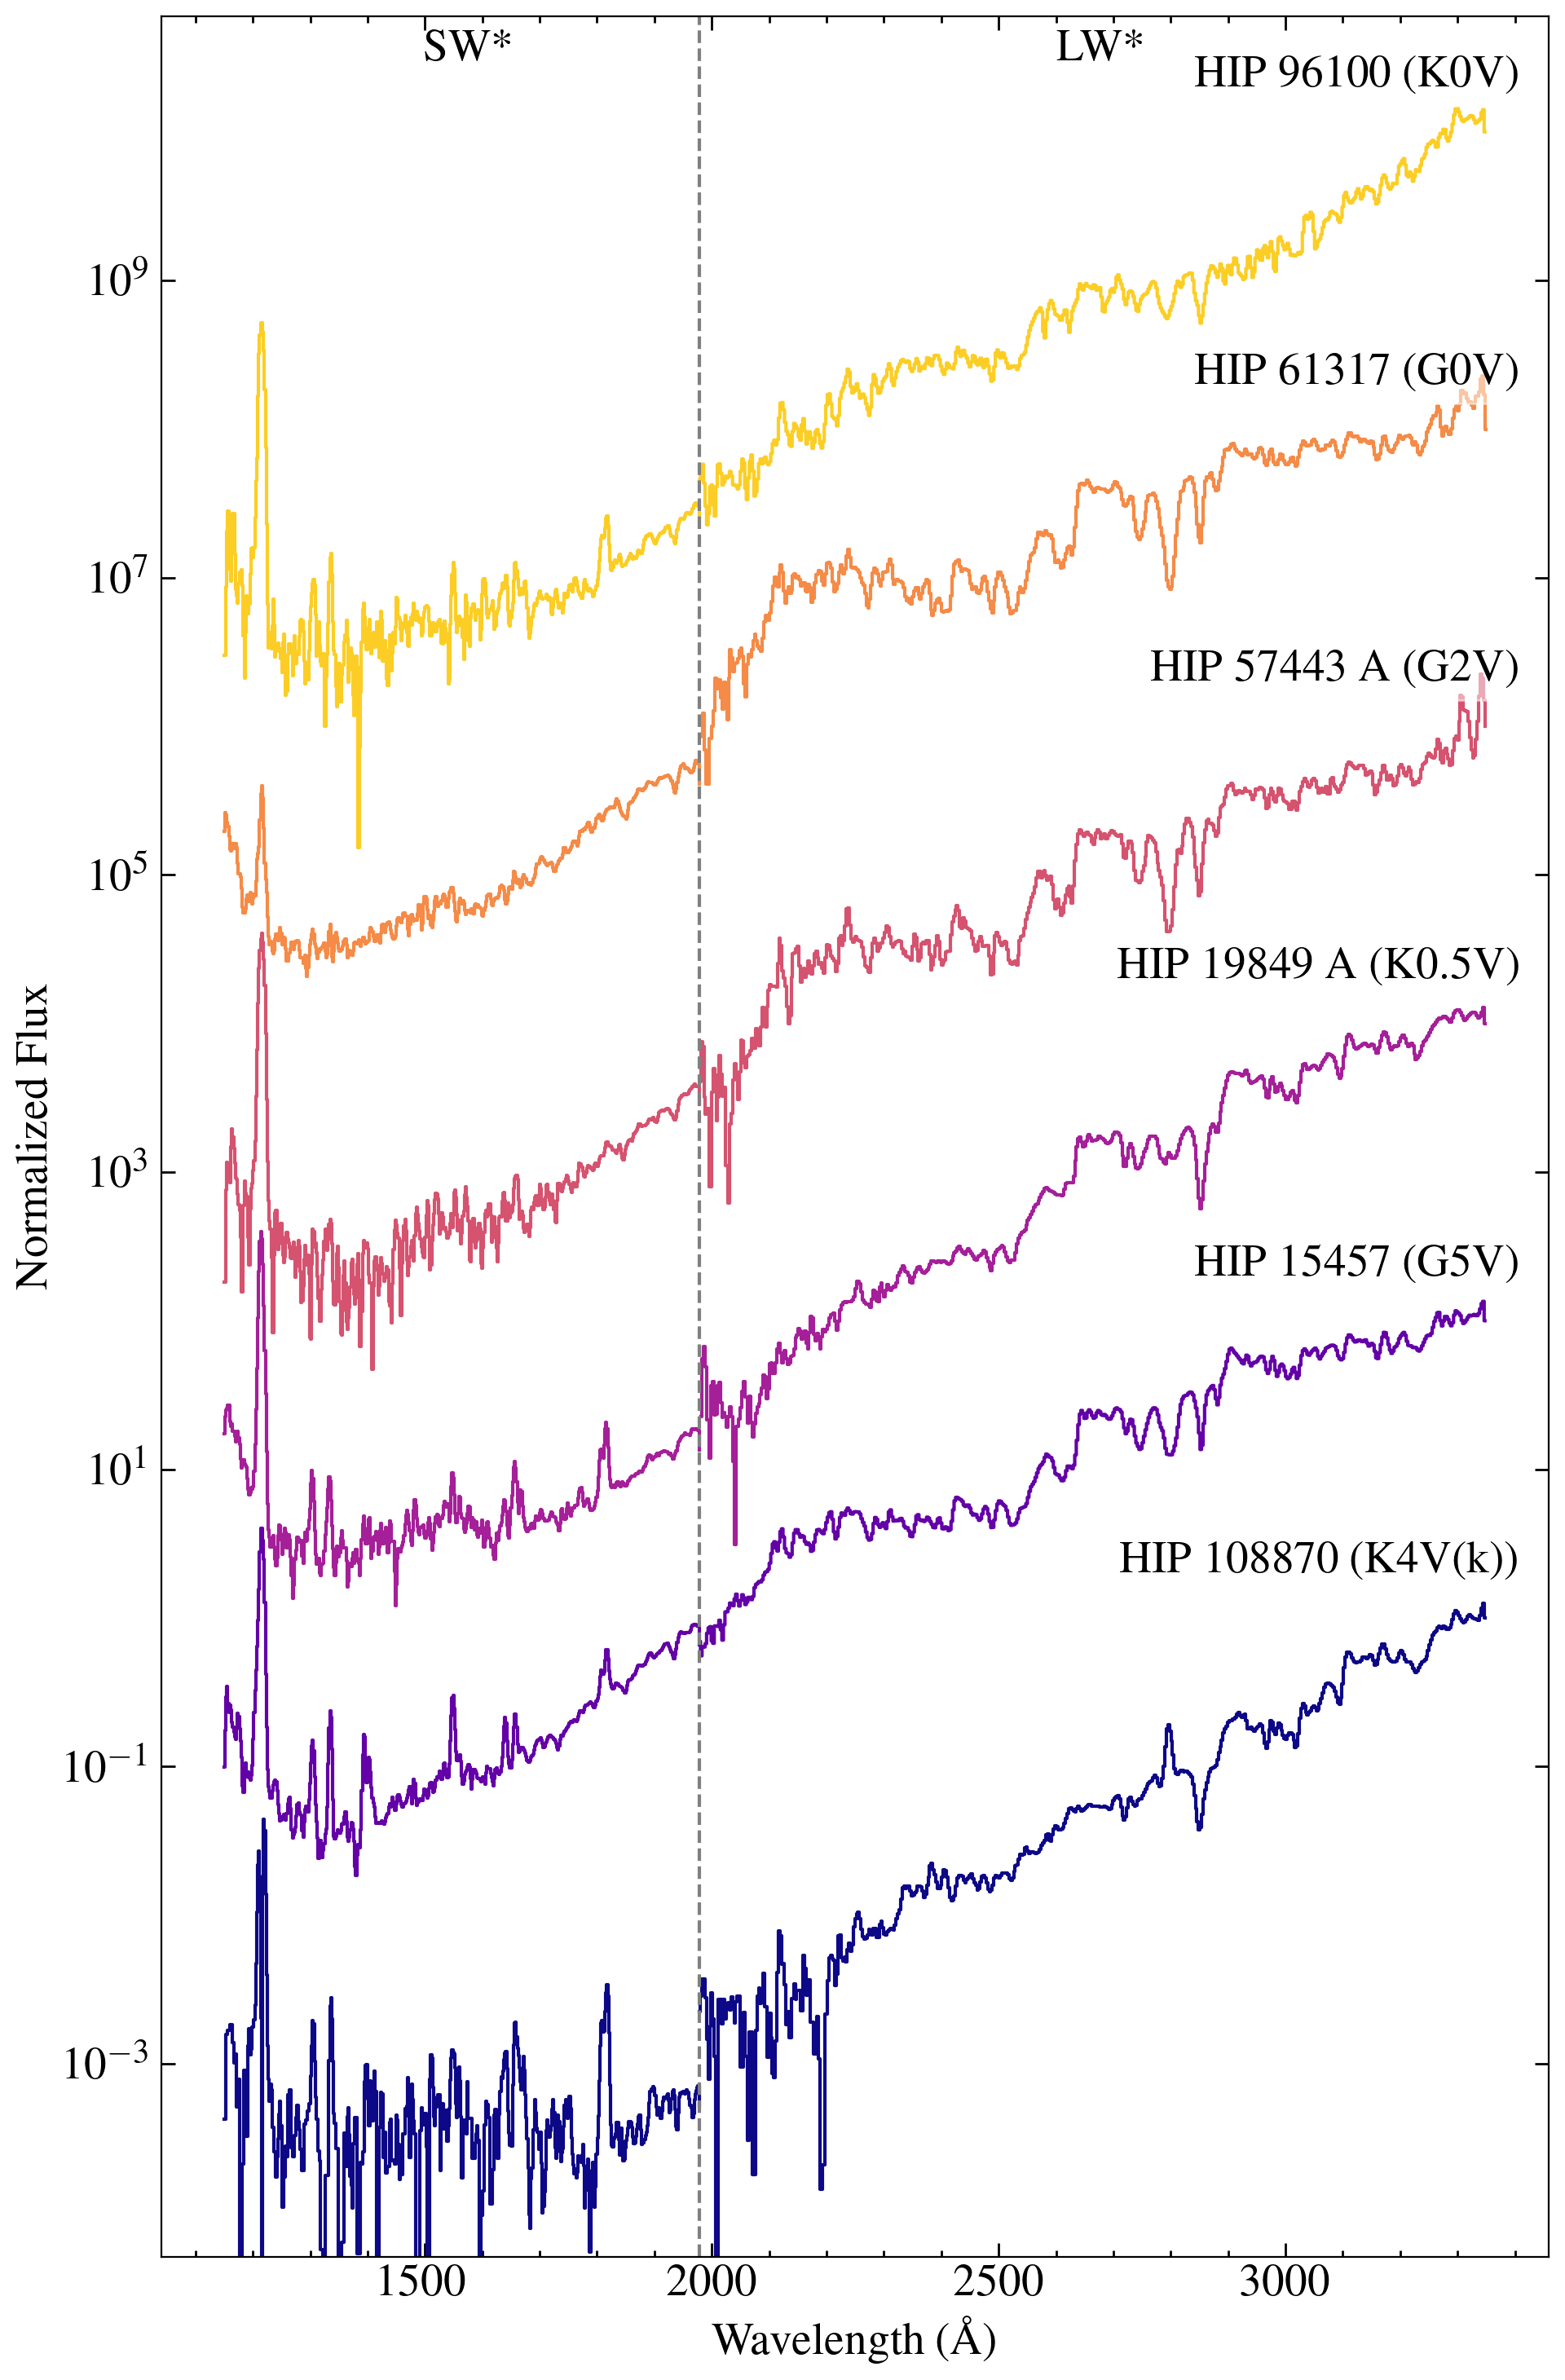

In [30]:
fig, ax = plt.subplots(figsize=(10, 15))

cols = np.linspace(0, 0.9, len(stars))

for i, star in enumerate(stars):
    
    # print(star)
    iuespecs = glob.glob('{}{}/*vo.fits'.format(path, star))
    
    
    sw_f = []
    sw_e = []
    lw_f = []
    lw_e = []
    n = 0
    o = 0
    for spec in iuespecs:
        data = fits.getdata(spec, 1)[0]
        w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
       
        if os.path.split(spec)[1][0:2] == 'sw':
            if n == 0:
                w_sw = w
                sw_f.append(f)
                sw_e.append(e)
            else:
                fi = interp1d(w, f, fill_value='extrapolate')(w_sw)
                ei = interp1d(w, e, fill_value='extrapolate')(w_sw)
                sw_f.append(fi)
                sw_e.append(ei)
            n += 1
        if os.path.split(spec)[1][0:2] == 'lw':
            if o == 0:
                w_lw = w
                lw_f.append(f)
                lw_e.append(e)
            else:
                fi = interp1d(w, f, fill_value='extrapolate')(w_lw)
                ei = interp1d(w, e, fill_value='extrapolate')(w_lw)
                lw_f.append(fi)
                lw_e.append(ei)
            o += 1
            
    # print(lwr_e)
    f_lw, e_lw = spectra_adder(np.array(lw_f), np.array(lw_e))
    f_sw, e_sw = spectra_adder(np.array(sw_f), np.array(sw_e))
                
        
            # ax.step(w[dq==0],f[dq==0], where='mid')
            # ax.step(w,f, where='mid')
            
    smask = (f_sw > 0) #& (w_swp < w_lw[0])
    lmask = (f_lw > 0) & (w_lw >= w_sw[-1])
    
    f_sw = convolve(f_sw,Box1DKernel(2))
    f_lw = convolve(f_lw,Box1DKernel(2))
    # e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    
    norm = 1/f_lw[-1]
    
    ax.step(w_lw[lmask], (f_lw[lmask]*norm)*100**i, where='mid', c=plt.cm.plasma(cols[i]))
    ax.step(w_sw[smask], (f_sw[smask]*norm)*100**i, where='mid', c=plt.cm.plasma(cols[i]))
    
    if star[-1] == 'A':
        tabname = star[0:-2]+'_'
    else:
        tabname = star+'_'
    row = np.where(startab['HIP#'] == tabname)[0][0]
    spt = startab['SpT'][row]
            
    ax.annotate(star.replace('_', ' ')+' ('+spt+')', (0.98, (100**i)*2), xycoords=('axes fraction', 'data'), 
                ha='right', bbox=dict(fc='w', ec='w', alpha=0.5))

ax.set_yscale('log')
ax.axvline(w_sw[-1], ls='--', c='0.5' )
ax.annotate(r'SW*', (1500, 3e10))
ax.annotate(r'LW*', (2600, 3e10))
    # ax.set_xscale('log')
    # ax.set_ylim(1e-15)
ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Normalized Flux')
ax.set_ylim(5e-5 , 6e10)

fig.tight_layout()

fig.savefig('plots/iue_best6.png', facecolor='w')
fig.savefig('plots/iue_best6.pdf')

# plt.show()

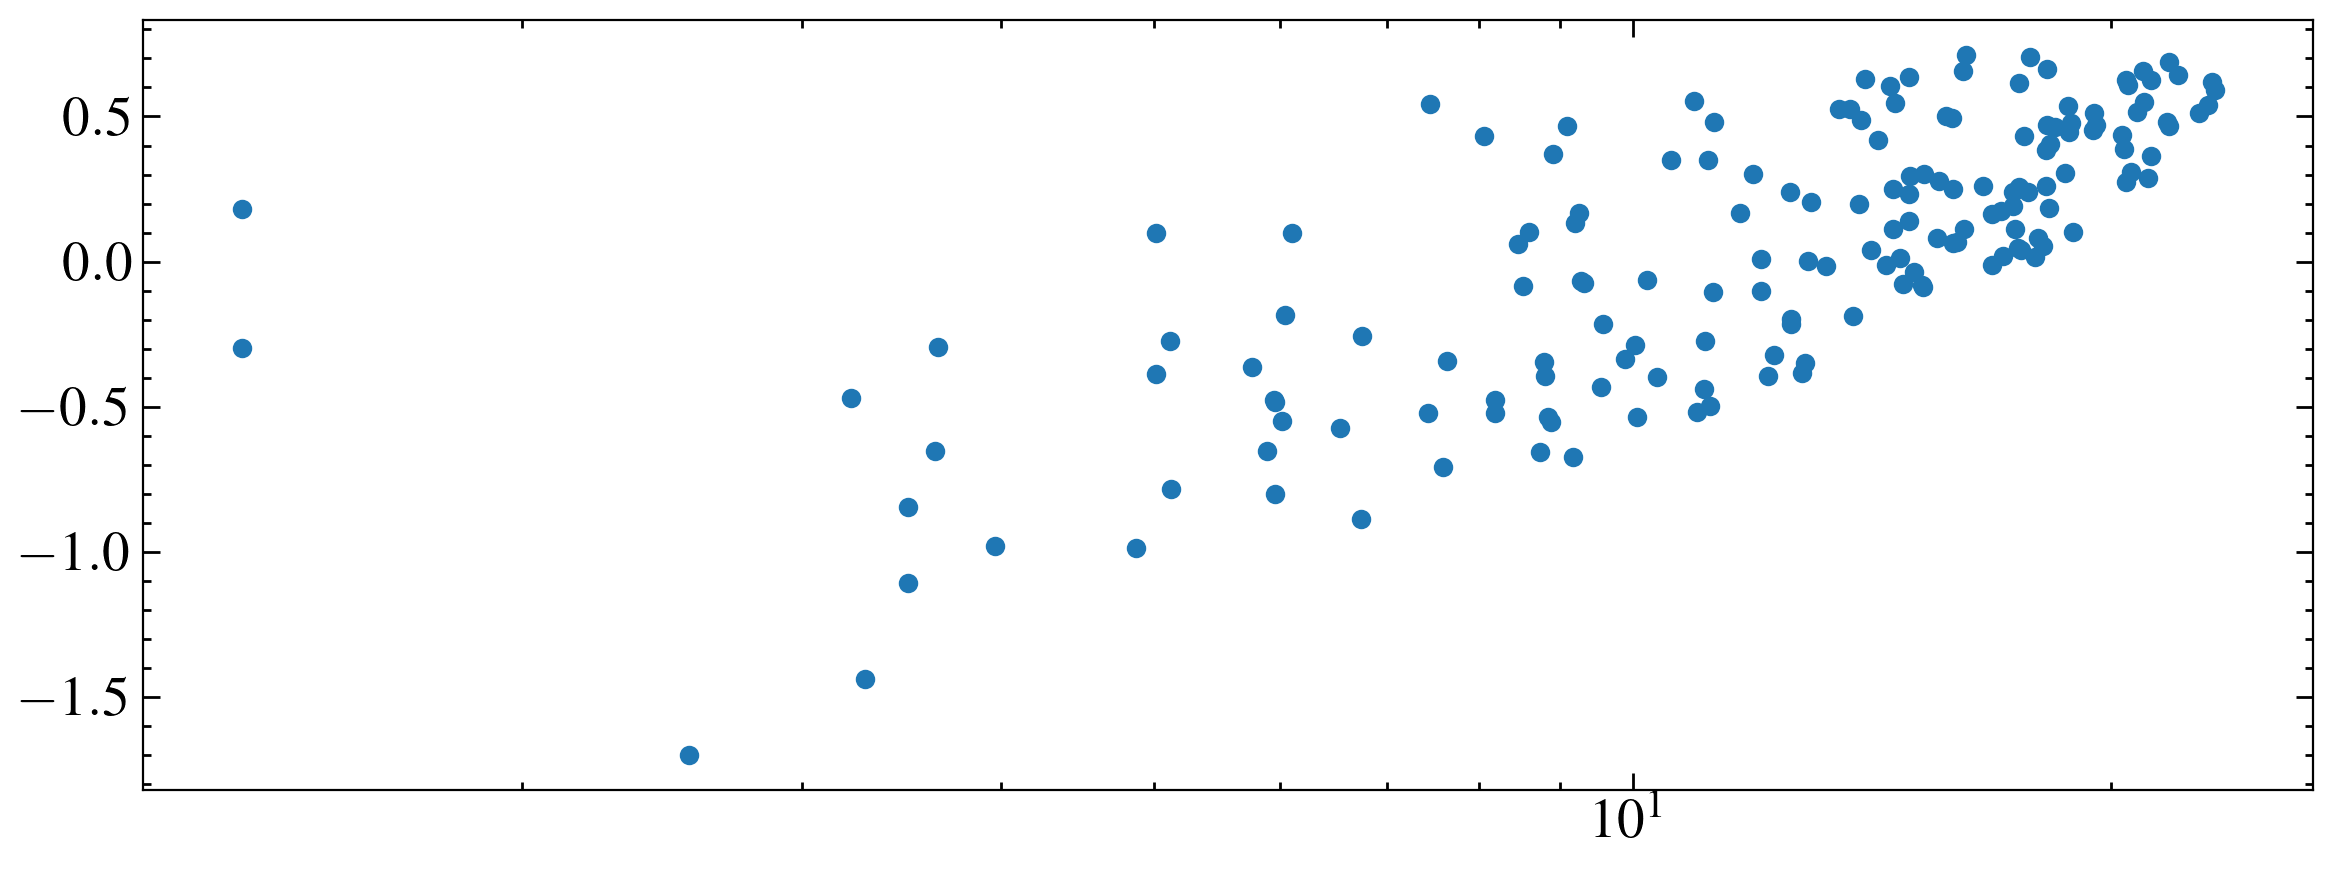

In [11]:
dist = startab['DistPc']
sep = startab['EEIDmas']
lbol = startab['log(L/Lsun)']
plt.scatter(dist, lbol)
# sep
# plt.yscale('log')
plt.xscale('log')

# dist

In [12]:
# for star in stars:
#     if star[-1] == 'A':
#         tabname = star[0:-2]+'_'
#     else:
#         tabname = star+'_'
#     row = np.where(startab['HIP#'] == tabname)[0][0]
#     # print(row)
#     # print(star, startab['SpT'][row])

Making a list of RAs and Decs for MAST 

In [32]:
tic, ra, dec = startab['TIC#'], startab['_RAJ2000'], startab['_DEJ2000']
coords = Table([tic, ra, dec], names = ['TIC#', 'RA', 'DEC'])
ascii.write(coords, 'star_coords.csv', format='csv')